In [1]:
# import necessary modules
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pickle

# Landscape Plotting Functions

In [2]:
"""
organizes run iteration data into 3 lists: 2 traits + 1 variable specific to the function
- score/drop functions gather final values
- population zone functions gather average positional data from a latter portion of model runs
"""

def pull_data_final_tscore(master_data):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(t_score[-1])
    return dps, pps, z_variable 

def pull_data_final_cscore(master_data):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(c_score[-1])
    return dps, pps, z_variable 

def pull_data_final_gscore(master_data):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(g_score[-1])
    return dps, pps, z_variable 

def pull_data_final_drops(master_data):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(drops[-1])
    return dps, pps, z_variable 

def pull_data_ss_forage_zone(master_data,ss_run_num):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(np.average(forage_zone[ss_run_num:]))
    return dps, pps, z_variable 

def pull_data_ss_tree_zone(master_data,ss_run_num):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(np.average(tree_zone[ss_run_num:]))
    return dps, pps, z_variable 

def pull_data_ss_nest_zone(master_data,ss_run_num):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(np.average(nest_zone[ss_run_num:]))
    return dps, pps, z_variable 

def pull_data_ss_foragenest_gap(master_data,ss_run_num):
    dps = []
    pps = []
    z_variable = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in master_data:
        dps.append(dp)
        pps.append(pp)
        z_variable.append(np.average(forage_zone[ss_run_num:])-np.average(nest_zone[ss_run_num:]))
    return dps, pps, z_variable 

In [3]:
def interpolate(data_input, interpolation_function='linear'):
    """
    Transforms raw iterated simulation data into condensed data structure
    Maps interpolated scores onto dense mesh grid of traits (dp x pp)
    
    Interpolation functions :
    
    'linear': r
    'cubic': r**3
    'quintic': r**5
    'thin_plate': r**2 * log(r)
    'gaussian': exp(-(r/self.epsilon)**2)
    'inverse': 1.0/sqrt((r/self.epsilon)**2 + 1)
    'multiquadric': sqrt((r/self.epsilon)**2 + 1)
    """
    # unpack data
    dps, pps, z_variable = data_input
    
    # convert into dictionary
    data_dict = {'drop_prob':dps, 
            'pickup_prob':pps, 
            'z_variable':z_variable}
    
    # output as 2D data structure via pandas DataFrame  
    df = pd.DataFrame(data_dict) 
    
    # align the repeated runs with same (dp x pp) + condense by averaging the scores
    means = df.groupby(['drop_prob', 'pickup_prob'], as_index=False)['z_variable'].mean()
    
    # set each data column to different axes
    x = means['pickup_prob']
    y = means['drop_prob']
    z = means['z_variable']
    
    # create mesh grid to map interpolation onto
    xi, yi = np.linspace(x.min(), x.max(), 101), np.linspace(y.min(), y.max(), 101)
    xi, yi = np.meshgrid(xi, yi)
    
    # interpolate the input dp x pp x score data
    rbf = scipy.interpolate.Rbf(x, y, z, function=interpolation_function)
    
    # map interpolation onto the mesh grid, creates a new estimated score for each grid position
    zi = rbf(xi, yi)
    
    return xi, yi, zi

In [4]:
def gradient_arrow_heatmap(interpolated_data, max_min, title, z_min=0, z_max=0,
                   normalize=True, vanishing_arrows=True, arrow_size=.5):
    """
    Calculates a mesh of arrows which shows direction and/or strength of gradient 
        along interpolated trait-score landscape
    Plots heatmap along with mesh with key design parameters:
    - normalize:
        - TRUE: arrows show direction only, gradient strength (arrow length) is equalized
    - vanishing_arrows:
        - TRUE: arrows with low gradient strength are displayed as dots
        - FALSE: arrows with low gradient strength are displayed as arrow heads
    """
    # unpacks interpolated output of interpolate()
    xi,yi,zi = interpolated_data
    
    # origins of arrows set to every 5 trait values in the middle of the grid (excluding 0, 100)
    a_min, a_max, a_stepsize = 5, 96, 5
    
    # discretizes interpolated data according to arrow origins
    xia = xi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    yia = yi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    zia = zi[a_min:a_max:a_stepsize, a_min:a_max:a_stepsize]
    
    # finds gradient of the interpolated score arrow matrix
    yig, xig = np.gradient(zia)
    
    # plot background heatmap from interpolated data
    plot_heatmap(interpolated_data, max_min, title, z_min, z_max)
    
    # decision hierarchy which decides plot design
    # normalizing disregards gradient strength >> arrows are same length + only show direction
    # vanishing_arrows uses quiver() >> minimum length arrows plot as dots
    # non-vanishing_arrows uses arrow() + vectorize() >> minimum length arrows plot as arrow heads
    
    if normalize == True:
        dx = xig / np.sqrt(xig**2 + yig**2)
        dy = yig / np.sqrt(xig**2 + yig**2)
        
        plt.quiver(xia, yia, dx, dy, headwidth=5, headlength=5)
            
    else: # normalize: False
        dx, dy = xig, yig
        
        if vanishing_arrows == True:
            plt.quiver(xia, yia, dx, dy, headwidth=5, headlength=5)
        else: # vanishing_arrows: False
            vectorized_arrow_drawing = np.vectorize(func_to_vectorize)
            vectorized_arrow_drawing(xia, yia, dx, dy, 0.01 * arrow_size)

    plt.show()
    
def plot_heatmap(interpolated_data, max_min, title, z_min, z_max, cmap=plt.cm.gist_rainbow):
    """
    Plots heatmap of interpolated trait-score data
    Called within gradient_arrow_heatmap()
    """
    # unpacks interpolated output of interpolate()
    xi,yi,zi = interpolated_data
    
    # if no max score is defined, uses the maximum interpolated value
    if z_max == 0:
        z_max = np.max(zi)
    
    # sets up figure
    _, ax = plt.subplots(figsize=(10, 10))
    ax.set_title(title)
    ax.set_xlabel('Pickup probability', fontsize=12)
    ax.set_ylabel('Drop probability', fontsize=12)
    
    # plots heatmap according to color scheme, bounded in the x/y/z directions
    hm = ax.imshow(zi, interpolation='none', cmap=cmap,
                extent=[xi.min(), xi.max(), yi.min(), yi.max()], origin=[0,0],
                vmin=z_min, vmax=z_max) 
    
    # adds color bar to the right side of heatmap
    cbar = plt.colorbar(hm)
    
    if max_min != 0:
        # pull max + min data
        dp_max, pp_max, z_max, dp_min, pp_min, z_min = max_min

        plt.plot(pp_max,dp_max,'ro')
        plt.plot(pp_min,dp_min,'bo')
        
def func_to_vectorize(x, y, dx, dy, scaling):
    """
    Used for plotting gradient arrows in conjunction with vectorize()
    Called within gradient_arrow_heatmap()
    """
    plt.arrow(x, y, dx*scaling, dy*scaling, fc="k", ec="k", head_width=1.5, head_length=1)

In [5]:
def linear_cost(data_nocost, max_cost, apply_pp_cost=True, apply_dp_cost=True, plot_cost=False):
    """
    Scales score by relative trait values of either/or dp + pp, bounded by max_cost
    Output mirrors the pull_data functions (3 lists)
    """
    dps = []
    pps = []
    scaled_scores = []
    for dp, pp, c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone in data_nocost:
        pp_cost = pp/100 * max_cost * apply_pp_cost
        dp_cost = dp/100 * max_cost * apply_dp_cost
        # score proportionally decreased by higher pp and/or dp trait values
        scaled_score = t_score[-1]*(1 - pp_cost - dp_cost)
        # builds lists
        dps.append(dp)
        pps.append(pp)
        scaled_scores.append(scaled_score)
    
    # plots cost function if called
    if plot_cost == True:
        x = np.linspace(0, 100, 101)
        y = x/100 * max_cost
        fig = plt.figure(figsize = (10, 5))
        plt.plot(x, y)
    
    return dps, pps, scaled_scores

In [6]:
def find_max_min(data, print_max=False, print_min=False):
    """
    Finds the max/min of a z_variable list, outputs this along with corresponding trait values
    """
    dps, pps, z_variables = data
    
    z_max = max(z_variables)
    index_max = z_variables.index(z_max)
    
    dp_max = dps[index_max]
    pp_max = pps[index_max]
    
    z_min = min(z_variables)
    index_min = z_variables.index(z_min)
    
    dp_min = dps[index_min]
    pp_min = pps[index_min]
    
    if print_max == True:
        print(f'pp_max: {pp_max}, dp_max: {dp_max}, z_max: {z_max}')
    if print_min == True:
        print(f'pp_min: {pp_min}, dp_min: {dp_min}, z_min: {z_min}')
    
    return dp_max, pp_max, z_max, dp_min, pp_min, z_min

# Plotting Final Total Score Landscapes

pp_max: 100, dp_max: 100, z_max: 840.9


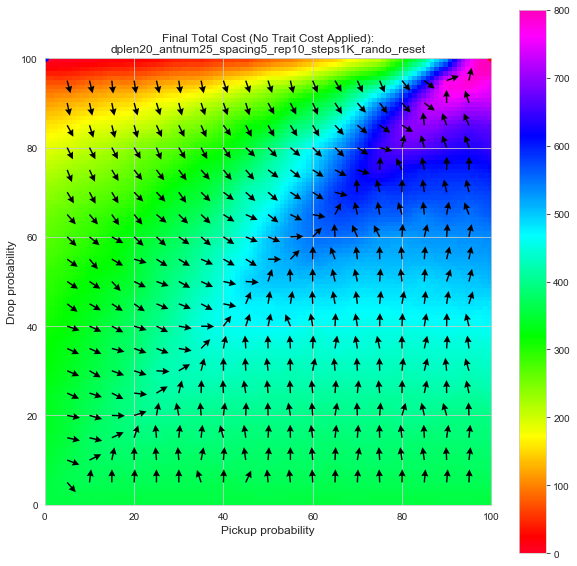

pp_max: 100, dp_max: 100, z_max: 588.63


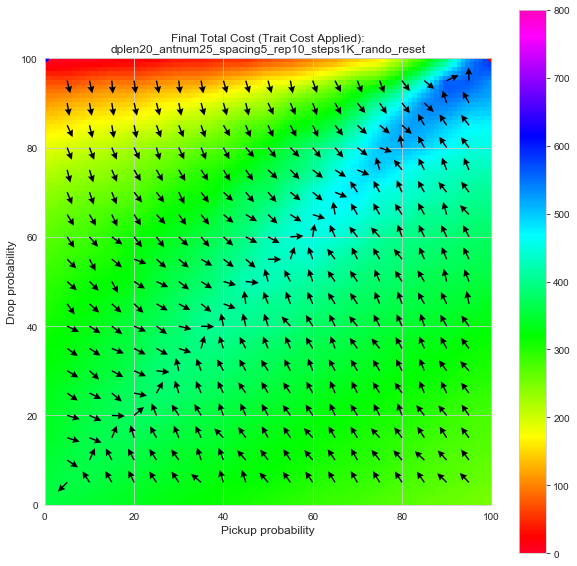

In [11]:
"""
plots heatmap landscapes using final total score data gathered in the ABM notebook file
both as raw data + after a trait behavioral adaptation cost has been applied 
- Trait Cost linearly scales with increasing pickup_probability
    - drop_probability already has 'cost' built in for high adaptation levels:
    ants can ignore dropped leaves, wasting the effort of the dropper
    - pickup_probability cost is where an ant would waste time looking for dropped leaves,
    e.g. wander, pick up non-leaf objects (behaviors not included in the simulation)
"""

# save filename to use in plot title + load landscape data
title = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
master_data = pickle.load(open(title,'rb'))

# maximum score value (z-variable in heatmap) for each landscape
plot_max = 800

# extract final total score data for each trait combination (drop + pickup probabilities)
data_nocost = pull_data_final_tscore(master_data)
# find the maximum + minimum final trait score + associated trait combinations, print the maximum
max_min = find_max_min(data_nocost, print_max=True)
# interpolate between the data points to create dense data mesh for plotting
interp_data_nocost = interpolate(data_nocost, 'linear')
# plot a heatmap + arrows to signify the gradient at equally spaced points throughout plot
gradient_arrow_heatmap(interp_data_nocost, max_min, 
    title=f'Final Total Cost (No Trait Cost Applied):\n{title}',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

# apply a cost that linearly scales with increasing pickup_probability 
# output data is in the same form as pull_data_final_tscore
data_cost = linear_cost(master_data, 0.3, apply_pp_cost=True, apply_dp_cost=False, plot_cost=False)
max_min = find_max_min(data_cost, print_max=True)
interp_data_cost = interpolate(data_cost, 'linear')
gradient_arrow_heatmap(interp_data_cost, max_min, 
    title=f'Final Total Cost (Trait Cost Applied):\n{title}', 
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

# Plotting Final Specific Output Landscapes

pp_max: 100, dp_max: 100, z_max: 840.9


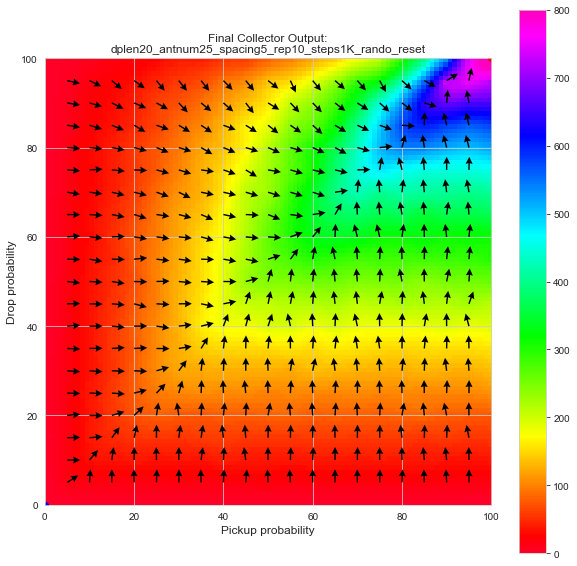

pp_max: 70, dp_max: 0, z_max: 358.8


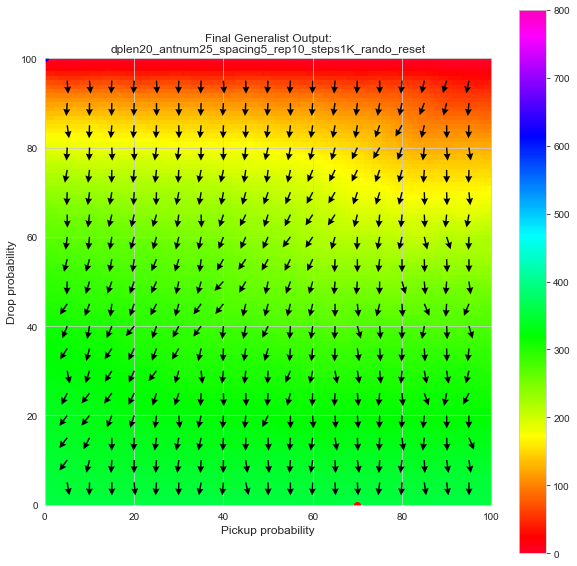

pp_max: 10, dp_max: 100, z_max: 1692.5


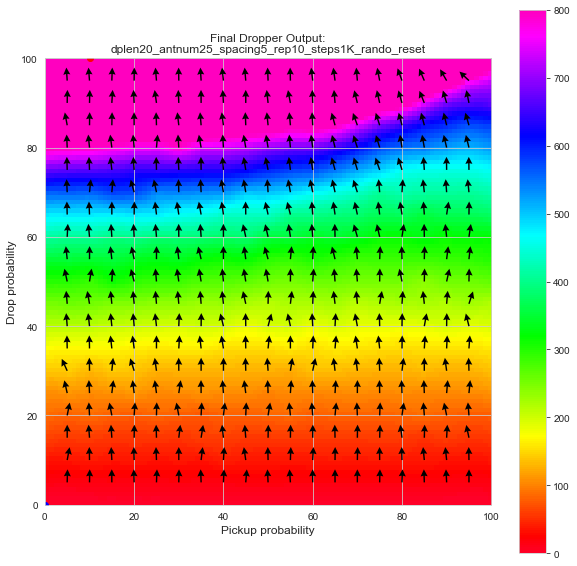

In [10]:
"""
plots heatmap landscapes using final specific output data gathered in the ABM notebook file
- Final Collector Output : number of leaves gathered by ants from the bottom of the tree
- Final Generalist Output : number of leaves gathered by ants from the top of the tree
- Final Dropper Output : number of leaves dropped (from the top of the tree)
"""

title = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
master_data = pickle.load(open(title,'rb'))

plot_max = 800

data = pull_data_final_cscore(master_data)
max_min = find_max_min(data, print_max=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min, title=f'Final Collector Output:\n{title}',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_final_gscore(master_data)
max_min = find_max_min(data, print_max=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min, title=f'Final Generalist Output:\n{title}',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_final_drops(master_data)
max_min = find_max_min(data, print_max=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min, title=f'Final Dropper Output:\n{title}',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

# Plotting Population Zone Landscapes

pp_max: 0, dp_max: 100, z_max: 17.542
pp_min: 5, dp_min: 0, z_min: 3.5493999999999994


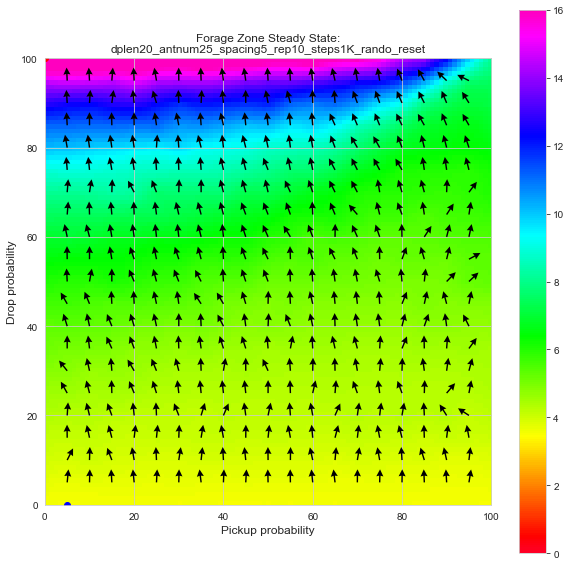

pp_max: 45, dp_max: 0, z_max: 17.4496
pp_min: 95, dp_min: 100, z_min: 6.2268


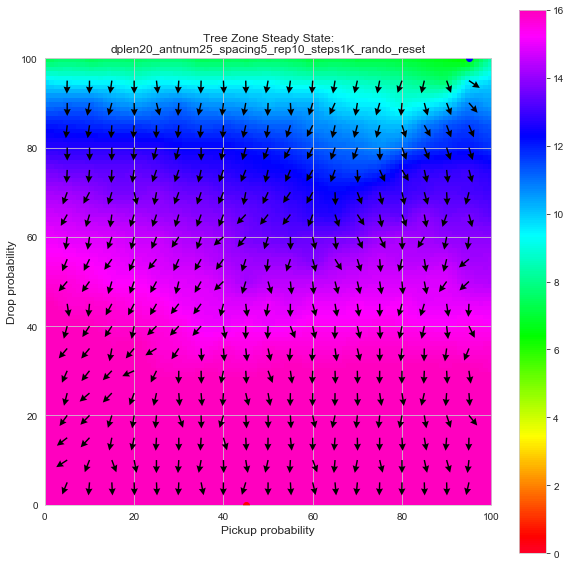

pp_max: 95, dp_max: 100, z_max: 8.799599999999998
pp_min: 0, dp_min: 100, z_min: 0.0


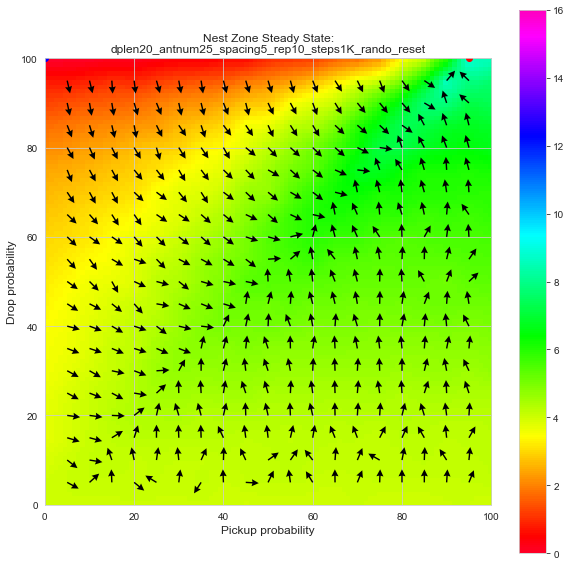

pp_max: 0, dp_max: 100, z_max: 17.542
pp_min: 5, dp_min: 0, z_min: -0.5032000000000005


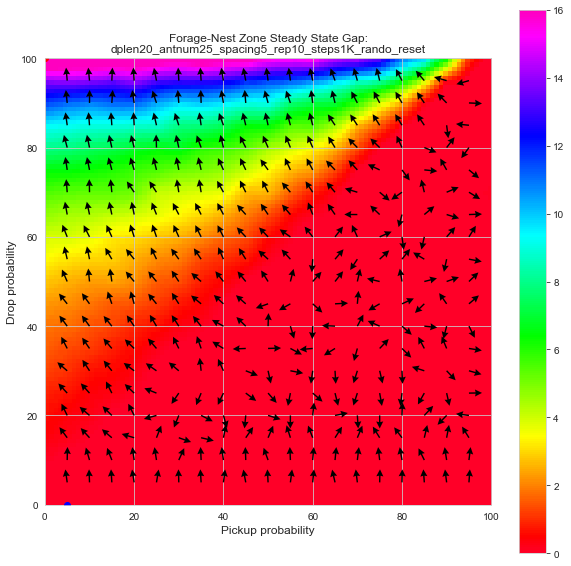

In [12]:
"""
plots heatmap landscapes using population zone data gathered in the ABM notebook file
- Forage Zone / Tree Zone / Nest Zone signify the three main areas of the simulation space
    - Forage/Tree zones are divided by the dropping cells the the top of the tree
    - Tree/Nest zones are divided by the cache (where the leaves drop to) at the bottom
- 'Steady State' is the average ant population in a zone from ss_run_num to the end of the run
- 'Forage-Nest Zone Gap' is the differene between the ant populations in the two zones,
reflecting the balance between the top populations with respect to trait combination
"""

title = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'
master_data = pickle.load(open(title,'rb'))

plot_max = 16
ss_run_num = 500

data = pull_data_ss_forage_zone(master_data,ss_run_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min, title=f'Forage Zone Steady State:\n{title}', 
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_ss_tree_zone(master_data,ss_run_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min, title=f'Tree Zone Steady State:\n{title}',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_ss_nest_zone(master_data,ss_run_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min, title=f'Nest Zone Steady State:\n{title}', 
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)

data = pull_data_ss_foragenest_gap(master_data,ss_run_num)
max_min = find_max_min(data, print_max=True, print_min=True)
interp_data = interpolate(data, 'linear')
gradient_arrow_heatmap(interp_data, max_min, title=f'Forage-Nest Zone Steady State Gap:\n{title}',
    z_max=plot_max, normalize=True, vanishing_arrows=True, arrow_size=.5)